In [1]:
#| export
verbose                       = None
check_memory_usage            = None
time_flag                     = None
window_size_percentage        = None
show_plots                    = None
reset_kernel                  = None
pre_configured_case           = False
case_id                       = 7
frequency_factor              = 1
frequency_factor_change_alias = False
check_parameters              = True
cuda_device                   = 0
move_files                    = False
example                       = ""

## Checking input parameters

In [2]:
if check_parameters:
    print("--- Check parameters ---")
    print(
        "verbose:", verbose,
        "check_memory_usage", check_memory_usage,
        "time_flag:", time_flag,
        "window_size_percentage:" , window_size_percentage,
        "show_plots:",show_plots,
        "reset_kernel:",reset_kernel,
        "pre_configured_case:",pre_configured_case,
        "case_id:",case_id,
        "frequency_factor:", frequency_factor, 
        "frequency_factor_change_alias", frequency_factor_change_alias,
        "cuda_device", cuda_device
)

--- Check parameters ---
verbose: None check_memory_usage None time_flag: None window_size_percentage: None show_plots: None reset_kernel: None pre_configured_case: False case_id: 7 frequency_factor: 1 frequency_factor_change_alias False cuda_device 0


## Set default input parameter values ensuring no errors
### Values explained below in their natural execution place

In [3]:
#| export
verbose                       = True  if verbose is None else verbose
check_memory_usage            = True  if check_memory_usage is None else check_memory_usage
time_flag                     = True  if time_flag is None else time_flag
window_size_percentage        = False if window_size_percentage is None else window_size_percentage
show_plots                    = True if show_plots is None else show_plots
reset_kernel                  = False  if reset_kernel is None else reset_kernel
pre_configured_case           = True if pre_configured_case is None else pre_configured_case
case_id                       = 7 if case_id is None else case_id
frequency_factor              = 1 if frequency_factor is None else frequency_factor
frequency_factor_change_alias = True if frequency_factor_change_alias is None else frequency_factor_change_alias
cuda_device                   = 1 if  cuda_device is None else cuda_device
move_files                    = False
example                       = "kohls"

In [4]:
if move_files:
    import _clean_yaml as yml
    import os
    example = example
    yml.copy_and_verify_yaml(
        wdb_user    = os.getenv("WANDB_ENTITY", "<>"), 
        wdb_project = os.getenv("WANDB_PROJECT", "<>"),
        example = example,
        verbose = 0
    )

In [5]:
if check_parameters:
    print("--- Check parameters ---")
    print(
        "verbose:", verbose,
        "check_memory_usage", check_memory_usage,
        "time_flag:", time_flag,
        "window_size_percentage:" , window_size_percentage,
        "show_plots:",show_plots,
        "reset_kernel:",reset_kernel,
        "pre_configured_case:",pre_configured_case,
        "case_id:",case_id,
        "frequency_factor:", frequency_factor, 
        "frequency_factor_change_alias", frequency_factor_change_alias,
        "cuda_device", cuda_device
)

--- Check parameters ---
verbose: True check_memory_usage True time_flag: True window_size_percentage: False show_plots: True reset_kernel: False pre_configured_case: False case_id: 7 frequency_factor: 1 frequency_factor_change_alias False cuda_device 0


# Encoder - MVP

> Self supervised learning Masked Value Prediction (MVP) as a way to create the embeddings.
Based on tsai's MVP

## Set-up
Initial notebook setup and specific debugging and pre-configured cases selection.
### VsCode update patch
Initial notebook setup when using VSCode.

In [6]:
#| export
# This is only needed if the notebook is run in VSCode
import sys
import dvats.utils as ut
if '--vscode' in sys.argv:
    print("Executing inside vscode")
    ut.DisplayHandle.update = ut.update_patch

/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/aeon/base/__init__.py:24: FutureWarning: The aeon package will soon be releasing v1.0.0 with the removal of legacy modules and interfaces such as BaseTransformer and BaseForecaster. This will contain breaking changes. See aeon-toolkit.org for more information. Set aeon.AEON_DEPRECATION_WARNING or the AEON_DEPRECATION_WARNING environmental variable to 'False' to disable this warning.
  warnings.warn(


### Debugging variables

- `verbose`. If ` > 0` it adds debbuging messages in those functions that allows so.
- `reset_kernel`. If `True` it resets the kernel by the end of the execution. Use only in case that memory management is needed.
- `check_memory_usage`. If `True`, it adds some lines for checking the GPU memmory ussage along the execution.
- `time_flag`. If `True` it get the execution time along the notebook as well as inside those functions that allows so.
- `window_size_percentage`. If `True`, MVP will be used directly with the proposed windows sizes. Otherwise, it will be asumed that they have been taken as absolute values and execution will be take that into account.
- `show_plots`. If `True` all plots are shown within the execution of the notebook. Otherwise, none of them will be plotted.

## Preconfigurated cases selection
- `pre_configured_case`. If `True`, a preconfigured case will be selected, forcing the artifact to get the expected configuration based on the information in `config\*.yml` and `utils\config.py`.
- `case_id`. If `preconfigured_case` is `True`, it forces to select the configuration of the `case_id` preconfigured samples. The available preconfigured samples are shown in the next cell.
- `frequency_factor`. If `pre_configured_case` is `True`, frequency will be resampled by `config.freq*frequency_factor`
  `frequency_factor_change_alias`. If `pre_configured_case` is `True` and `frequency_factor != 1` then the dataset alias will be modified for adding the new frequency as suffix.

In [7]:
#| export
import dvats.config as cfg_

In [8]:
#| hide
cfg_.show_available_configs()

Available datasets: 
0 - monash_australian_electricity_demand_0
1 - monash_solar_4_seconds_0
2 - wikipedia_0
3 - traffic_san_francisco_0
4 - monash_solar_10_minutes_0
5 - etth1_0
6 - stumpy_abp_0
7 - stumpy_toy_0


## Main code
### Import libraries

In [9]:
#| export
import warnings
warnings.filterwarnings("ignore", module="umap")
import os
import sys
sys.path.append(os.path.abspath('..'))
from dvats.all import *
from fastcore.all import *
from tsai.basics import *
from tsai.models.InceptionTimePlus import *
from tsai.callback.MVP import *
import matplotlib.colors as colors
from fastai.callback.wandb import WandbCallback
from fastai.callback.progress import ShowGraphCallback
from fastai.callback.schedule import *
from fastai.callback.tracker import EarlyStoppingCallback
import wandb


Octave is ready <oct2py.core.Oct2Py object at 0x7f53e349ef50>

















### Initialize and Configurate Artifact

In [10]:
#| export
wandb_api = wandb.Api()

#### Setup CUDA

In [11]:
#| export
device = torch.device(f'cuda:{cuda_device}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device)
if check_memory_usage:
    gpu_device = torch.cuda.current_device()
    gpu_memory_status(gpu_device)

GPU | Used mem: 41
GPU | Used mem: 48
GPU | Memory Usage: [█████████████████---] 85%


### Get configutation from yml
> This file used the configuration files './config/base.yml' and './config/02b_encoder_MVP.ipynb'

In [12]:
#| export
user, project, version, data, config, job_type = cfg_.get_artifact_config_MVP(False)
if pre_configured_case: 
    cfg_.force_artifact_config_mvp(
        config = config,
        id = case_id,
        verbose = verbose, 
        both = verbose > 0,
        frequency_factor = frequency_factor,
        frequency_factor_change_alias = frequency_factor_change_alias
    )

### Setup Weights & biases artiffact

In [13]:
#| export
path = os.path.expanduser("~/work/nbs_pipeline/")
name="02a_encoder_MVP"
os.environ["WANDB_NOTEBOOK_NAME"] = path+name+".ipynb"
runname=name
if verbose > 0: print("runname: "+runname)
if verbose > 0: cfg_.show_attrdict(config)

runname: 02a_encoder_MVP
alias: gtrends_kohls
analysis_mode: online
batch_size: 16
epochs: 200
mask_future: True
mask_stateful: False
mask_sync: False
mvp_ws: (12, 17)
norm_by_sample: False
norm_use_single_batch: False
r: 0.4
stride: 1
train_artifact: mi-santamaria/deepvats/gtrends_kohls:v2
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 17
wandb_group: None


In [14]:
#| export
if verbose > 0: print("--> Wandb init")
run = wandb.init(
    entity = user,
    # work-nbs is a place to log draft runs
    project=project,
    group=config.wandb_group,
    job_type=job_type,
    allow_val_change=True,
    mode=config.analysis_mode,
    config=config,
    # When use_wandb is false the run is not linked to a personal account
    #NOTE: This is not working right now
    anonymous = 'never' if config.use_wandb else 'must', 
    resume=False,
    name = runname
)
if verbose > 0: print("Wandb init -->")
config = run.config  # Object for storing hyperparameters
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact


--> Wandb init


wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find /home/macu/work/nbs_pipeline/02a_encoder_MVP.ipynb.
wandb: Currently logged in as: mi-santamaria. Use `wandb login --relogin` to force relogin


Wandb init -->


## Split data using Sliding Window & Get training artiffact

### Get W&B train artifact
Build artifact selector
Botch to use artifacts offline

In [15]:
#| export
config = run.config  # Object for storing hyperparameters
if verbose > 0: cfg_.show_attrdict(config)
artifacts_gettr = run.use_artifact if config.use_wandb else wandb_api.artifact
train_artifact = artifacts_gettr(config.train_artifact)
if verbose > 0: print("---> W&B Train Artifact")


alias: gtrends_kohls
analysis_mode: online
batch_size: 16
epochs: 200
mask_future: True
mask_stateful: False
mask_sync: False
mvp_ws: [12, 17]
norm_by_sample: False
norm_use_single_batch: False
r: 0.4
stride: 1
train_artifact: mi-santamaria/deepvats/gtrends_kohls:v2
valid_artifact: None
use_wandb: True
valid_size: 0.2
w: 17
wandb_group: None
---> W&B Train Artifact


In [16]:
# Testeando qué pasa con freq_factor 5
@patch
def to_df(self:wandb.apis.public.Artifact, verbose:int = 0):
    "Download the files of a saved wandb artifact and process them as a single dataframe. The artifact must \
    come from a call to `run.use_artifact` with a proper wandb run."
    # The way we have to ensure that the argument comes from a TS arfitact is the metadata
    if self.metadata.get('TS') is None:
        print(f'ERROR:{self} does not come from a logged TSArtifact')
        return None
    dir = Path(self.download())
    if verbose > 0: print(f"Dir: {dir}")
    if self.metadata['TS']['created'] == 'from-df':
        # Call read_pickle with the single file from dir
        #return pd.read_pickle(dir.ls()[0])
        return ft.read_feather(dir.ls()[0])
    else:
        print("ERROR: Only from_df method is allowed yet")

In [17]:
#| export
import pyarrow.feather as ft
df_train = train_artifact.to_df(1)
df_train.shape

wandb:   1 of 1 files downloaded.  


Dir: artifacts/gtrends_kohls:v2


(440, 1)

In [18]:
print(df_train.shape)
display(df_train.head())

(440, 1)


,volume
2004-01-01,0.010417
2004-01-08,0.010417
2004-01-15,0.010417
2004-01-22,0.000000
2004-01-29,0.000000


In [19]:
#| export
if verbose > 0: 
    print(df_train.shape)
    display(df_train.head)
    print("df_train ~ ", df_train.shape)
    print("window_sizes = ", config.mvp_ws)
    print("wlen = ", config.w)
    df_train.head

(440, 1)


<bound method NDFrame.head of               volume
2004-01-01  0.010417
2004-01-08  0.010417
2004-01-15  0.010417
2004-01-22  0.000000
2004-01-29  0.000000
...              ...
2012-05-03  0.322917
2012-05-10  0.312500
2012-05-17  0.281250
2012-05-24  0.291667
2012-05-31  0.322917

[440 rows x 1 columns]>

df_train ~  (440, 1)
window_sizes =  [12, 17]
wlen =  17


#### Get training set
Once we have build the windows, we can apply strides in order to check have the same structure as when used via sliding window

In [20]:
#| export
if verbose > 0: print("---> Sliding window | ", config.w,  " | ", config.stride )
sw = SlidingWindow(window_len=config.w, stride=config.stride, get_y=[])
if verbose > 0: print(" Sliding window | ", config.w,  " | ", config.stride, "---> | df_train ~ ", df_train.shape )
X_train, _ = sw(df_train)
if verbose > 0: print(" sw_df_train | ", config.w,  " | ", config.stride, "--->" )

---> Sliding window |  17  |  1
 Sliding window |  17  |  1 ---> | df_train ~  (440, 1)
 sw_df_train |  17  |  1 --->


In [21]:
#| hide
if verbose > 0: 
    print(X_train.shape)

(424, 1, 17)


### Split training set into training and test dataset

len(X):  424
--> Split 1


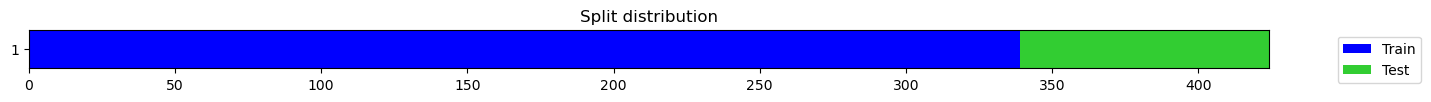

Split --> 339


In [22]:
#| export
assert config.analysis_mode in ['offline','online'], 'Invalid analysis mode'

X = X_train
if verbose > 0: print("len(X): ", len(X));
if config.analysis_mode == 'online':
    if verbose > 0: print("--> Split 1")
    splits = TimeSplitter(valid_size=0.2, show_plot=show_plots)(X)
elif config.analysis_mode == 'offline':
    if verbose > 0: print("--> Split 2")
    splits = get_splits(np.arange(len(X)), valid_size=config.valid_size, show_plot = show_plots)
if verbose > 0: 
    print("Split -->", len(splits[0]))


In [23]:
#| hide
if verbose > 0: 
    print(X.shape)
    display(splits)

(424, 1, 17)


((#339) [0,1,2,3,4,5,6,7,8,9...],
 (#85) [339,340,341,342,343,344,345,346,347,348...])

## MVP - Encoder training
> Train MVP with optional adaptable window sizes, to allow for inference with different
window sizes, to provide an easier exploration of the embedding space through different
ways of sliding the data.

### Set callback list

In [24]:
#| export
if verbose > 0: print("--> About to set callbacks")
cbs = L(WandbCallback(log_preds=False)) if config.use_wandb else L()

--> About to set callbacks


### Set transformations

In [25]:
#| export
if verbose > 0: print("--> About to set batch tfms")
tfms = [ToFloat(), None]
batch_tfms = [TSStandardize(by_sample=config.norm_by_sample, 
               use_single_batch=config.norm_use_single_batch)]

--> About to set batch tfms


### Get data loaders

In [26]:
#| export
dls = get_ts_dls(X, splits=splits, tfms=tfms, bs=config.batch_size, batch_tfms=batch_tfms)
if verbose > 0: print("get dls -->")

get dls -->


In [27]:
dls.train

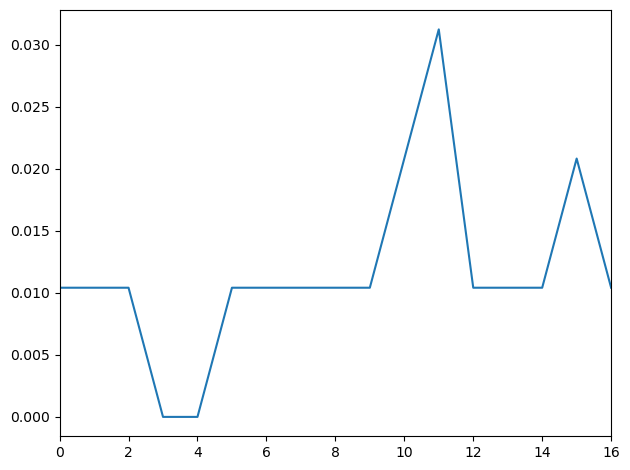

None

In [28]:
#| hide
if show_plots: display(dls.show_at(0))

### Build MVP TS Learner

In [29]:
#| hide
if show_plots:
    if verbose > 0: print("--> sgc")
    sgc = ShowGraphCallback2()
    if verbose > 0: print("sgc -->")
    if verbose > 0: print("-->learn")

--> sgc
sgc -->
-->learn


In [30]:
# + tags=["skip"]
#| hide
if show_plots: 
    print("\t learn | cbs + sgc + MVP")
    learn = ts_learner(
        dls, 
        InceptionTimePlus, 
        cbs= cbs + sgc + MVP(
            r = config.r, 
            window_size=config.mvp_ws, 
            future_mask = config.mask_future, 
            target_dir='./models', 
            sync = config.mask_sync, 
            stateful = config.mask_stateful,
            fname=f'encoder_MVP'
        ), y_range=[X.min(), X.max()])
    


	 learn | cbs + sgc + MVP


In [31]:
config.mvp_ws

[12, 17]

In [32]:
#| export
if not show_plots: #When .py this is the only option that should be available. That's why this is not an 'else' but a exported cell
    print("\t learn | cbs + MVP")
    learn = ts_learner(
        dls, 
        InceptionTimePlus, 
        cbs= cbs + MVP(
            r = config.r, 
            window_size=config.mvp_ws, 
            future_mask = config.mask_future, 
            target_dir='./models', 
            sync = config.mask_sync, 
            stateful = config.mask_stateful,
            fname=f'encoder_MVP'
        ), y_range=[X.min(), X.max()])
    
if verbose > 0: print("learn -->")

learn -->


In [33]:
#| hide
type(learn)

fastai.learner.Learner

### Example mask

#### Create mask

In [34]:
#| hide
if config.mask_future:
    example_mask = create_future_mask(torch.from_numpy(X[0]), config.r, sync=config.mask_sync)
else:
    example_mask = create_subsequence_mask(torch.from_numpy(X[0]), config.r, stateful=config.mask_stateful, sync=config.mask_sync)

#### Show mask

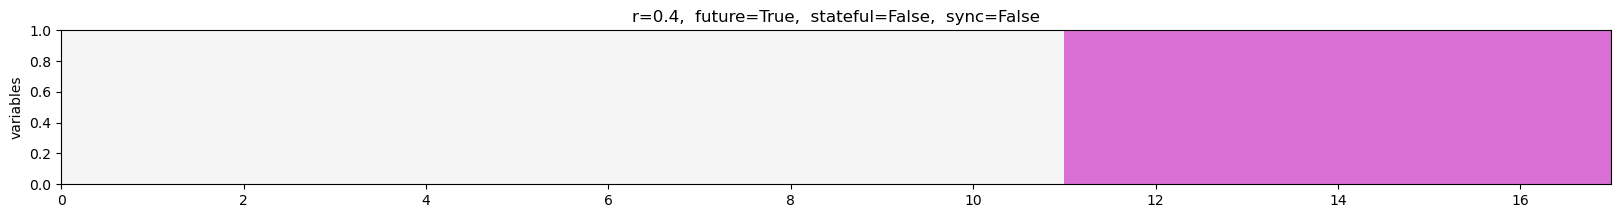

In [35]:
#| hide
fig, ax = plt.subplots(figsize=(20, 2))
plt.pcolormesh(example_mask[0], cmap=colors.ListedColormap(['whitesmoke', 'orchid']))
plt.title(f'r={config.r},  future={config.mask_future},  stateful={config.mask_stateful},  sync={config.mask_sync}')
ax.set_ylabel('variables')
plt.show()

 ## Check window size configuration

### Check config attributes

In [36]:
#| export
expected_window_size = config.mvp_ws

In [37]:
#| hide
if verbose > 0:
    print("w", config.w, "mvp_ws", config.mvp_ws)
    print("expected ", expected_window_size)


w 17 mvp_ws [12, 17]
expected  [12, 17]


### Check obtained attributes

In [38]:
#| export
mvp_cb = learn.cbs.filter(lambda cb: isinstance(cb, MVP))[0]  # Encuentra el callback MVP
obtained_window_size=mvp_cb.window_size

In [39]:
#| hide
if verbose > 0: 
    print("obtained ", obtained_window_size)

obtained  [12, 17]


In [40]:
#| export
if (expected_window_size != obtained_window_size):
    raise ValueError("Obtained window_size for MVP training different from expected window size. Check size, ws1 & ws2 parameters in '02b-encoder_MVP.yaml'")
else: 
    print("Obtained window size tuple is the expected one. Continue!")

Obtained window size tuple is the expected one. Continue!


#### Check w1 < w2 for MVP random window size selection

In [41]:
#| export
if (obtained_window_size[1] < obtained_window_size[0]):
    raise ValueError("Ws2 must be greater than Ws1 as they are the maximun and minimum window size respectively. Please ensure w2 > w1")
else: 
    w_sizes = np.random.randint(obtained_window_size)

In [42]:
# + tags=["skip"]
#| hide 
if verbose > 0: print(w_sizes)

[ 4 11]


#### Check self.x.shape[-1] for np.random.randint(0, self.x.shape[-1] - ws) MVP calculus

In [43]:
#| export
#Get data batch
x = next(iter(dls.train))
if verbose > 0: print("x", x)
x_data=x[0]
if verbose > 0: print("Data shape: " + str( x_data.shape))
time_serie_len = x_data.shape[-1]
if verbose > 0: print("Time serie len: " + str( time_serie_len))
#Just in case
for ws in w_sizes:
    diff = time_serie_len - ws
    if verbose > 0: print("diff time serie len - ws", diff)
    result = np.random.randint(0, diff)
    if verbose > 0: print("ws ", ws, "diff", diff, "result",  result)

x (TSTensor(samples:16, vars:1, len:17, device=cuda:0, dtype=torch.float32),)
Data shape: torch.Size([16, 1, 17])
Time serie len: 17
diff time serie len - ws 13
ws  4 diff 13 result 11
diff time serie len - ws 6
ws  11 diff 6 result 0


### Train the model

In [44]:
timer = ut.Time()
timer.start()

1741547531.6031203

--> Train


epoch,train_loss,valid_loss,time
0,0.611721,8.467718,00:00
1,0.519210,3.748239,00:00
2,0.479423,3.368379,00:00
3,0.443177,6.628976,00:00
4,0.407695,2.714734,00:00
5,0.388951,2.718256,00:00
6,0.395158,4.006359,00:00
7,0.389549,2.255942,00:00
8,0.381660,4.519743,00:00
9,0.360834,3.885668,00:00


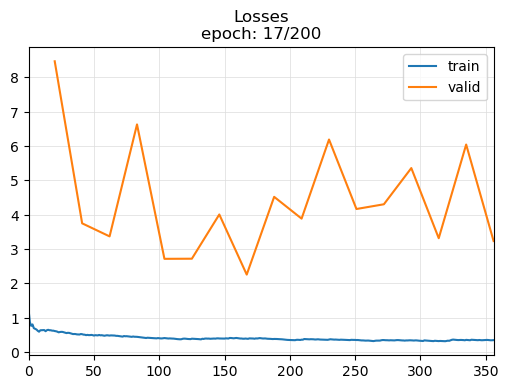

No improvement since epoch 7: early stopping


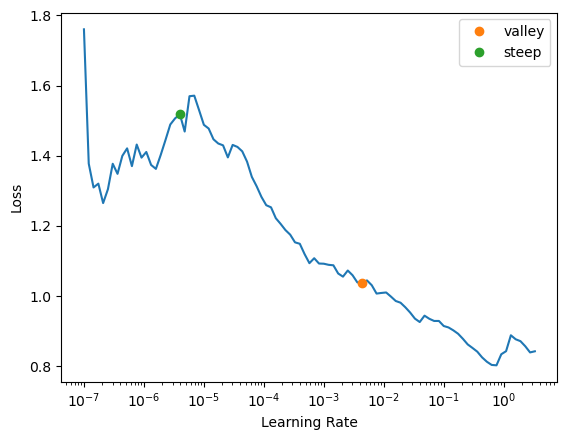

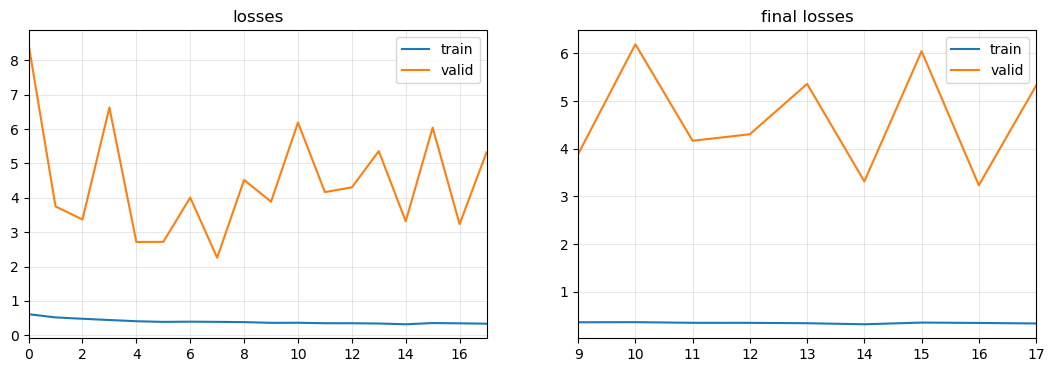

In [45]:
#| export
if verbose > 0: print("--> Train")
lr_valley, lr_steep = learn.lr_find(suggest_funcs=(valley, steep), show_plot=show_plots)
learn.fit_one_cycle(n_epoch=config.epochs, lr_max=lr_valley,  cbs=[EarlyStoppingCallback(monitor='valid_loss', min_delta=0.000001, patience=10)])

In [46]:
timer.end()
timer.show()

23.866913557052612

#### Validate the model

In [47]:
learn.__class__

fastai.learner.Learner

In [48]:
#| export
if verbose > 0: print("Train -->")
learn.validate()
if verbose > 0: print("Validate -->")

Train -->


not enough values to plot a chart
Validate -->


In [72]:
for i, batch in enumerate(dls.valid):
    print(f"Batch {i+1}: {type(batch)}")
    if isinstance(batch, (list, tuple)):  # Para comprobar si es una tupla de (inputs, labels)
        print(f"  Input shape: {batch[0].shape}")
        if len(batch) > 1:
            print(f"  Target shape: {batch[1].shape}")
    else:
        print(f"  Shape: {batch.shape}")  # Si batch no es una tupla/lista
    

Batch 1: <class 'tuple'>
  Input shape: torch.Size([16, 1, 17])
Batch 2: <class 'tuple'>
  Input shape: torch.Size([16, 1, 17])
Batch 3: <class 'tuple'>
  Input shape: torch.Size([16, 1, 17])
Batch 4: <class 'tuple'>
  Input shape: torch.Size([16, 1, 17])
Batch 5: <class 'tuple'>
  Input shape: torch.Size([16, 1, 17])
Batch 6: <class 'tuple'>
  Input shape: torch.Size([5, 1, 17])


In [50]:
def check_layers(learn):
    # ANSI escape codes para color rojo y negrita en la consola
    RED = "\033[91m"
    BOLD = "\033[1m"
    RESET = "\033[0m"

    seen_layers = set()
    param_dict = {name: param.shape for name, param in learn.model.named_parameters()}

    def recurse_layers(module, prefix="", depth=0):
        """Recorre todas las capas del modelo y muestra solo sus parámetros directos."""
        for name, layer in module.named_children():  # Obtiene todos los submódulos
            full_name = f"{prefix}.{name}" if prefix else name

            # Aplicar negrita solo la primera vez que aparece un nombre de capa
            formatted_name = f"{BOLD}{name}{RESET}" if full_name not in seen_layers else name
            seen_layers.add(full_name)

            indentation = "\t" * depth  # Agregar tabulación según la profundidad
            
            # Filtrar solo los parámetros **directamente dentro** de esta capa
            param_info = [
                f"{n.split('.')[-1]}: {param_dict[n]}"
                for n in param_dict
                if n.startswith(full_name) and n.count('.') == full_name.count('.') + 1
            ]
            param_text = f" | Parámetros: {', '.join(param_info)}" if param_info else ""

            print(f"{indentation}[{depth}] Capa {formatted_name} {RED}[{type(layer).__name__}]{RESET}{param_text}")

            # Recursivamente mostrar las subcapas
            recurse_layers(layer, full_name, depth + 1)

    # Iniciar el recorrido desde el modelo completo
    recurse_layers(learn.model)

check_layers(learn)


[0] Capa backbone [Sequential]
	[1] Capa 0 [InceptionBlockPlus]
		[2] Capa inception [ModuleList]
			[3] Capa 0 [InceptionModulePlus]
				[4] Capa bottleneck [ConvBlock]
					[5] Capa 0 [Conv1d] | Parámetros: weight: torch.Size([32, 1, 1])
				[4] Capa convs [ModuleList]
					[5] Capa 0 [ConvBlock]
						[6] Capa 0 [Conv1d] | Parámetros: weight: torch.Size([32, 32, 39])
					[5] Capa 1 [ConvBlock]
						[6] Capa 0 [Conv1d] | Parámetros: weight: torch.Size([32, 32, 19])
					[5] Capa 2 [ConvBlock]
						[6] Capa 0 [Conv1d] | Parámetros: weight: torch.Size([32, 32, 9])
				[4] Capa mp_conv [Sequential]
					[5] Capa 0 [MaxPool1d]
					[5] Capa 1 [ConvBlock]
						[6] Capa 0 [Conv1d] | Parámetros: weight: torch.Size([32, 1, 1])
				[4] Capa concat [Concat]
				[4] Capa norm [BatchNorm1d] | Parámetros: weight: torch.Size([128]), bias: torch.Size([128])
				[4] Capa act [ReLU]
			[3] Capa 1 [InceptionModulePlus]
				[4] Capa bottleneck [ConvBlock]
					[5] Capa 0 [Conv1d] | Parámetros: weig

In [51]:
print(learn.validate()[0])

not enough values to plot a chart
10.386970520019531


In [52]:
print("🛠 Transformaciones en after_item:", learn.dls.valid.after_item)
print("🛠 Transformaciones en after_batch:", learn.dls.valid.after_batch)

🛠 Transformaciones en after_item: Pipeline: 
🛠 Transformaciones en after_batch: Pipeline: TSStandardize


In [53]:
# Desactivar TSStandardize en la validación
learn.dls.valid.after_batch = Pipeline([])

In [54]:
learn_bkup = deepcopy(learn)

In [55]:
learn = deepcopy(learn_bkup)

In [56]:
for cb in learn.cbs:
    print(f"🔍 Callback activo: {cb}")

🔍 Callback activo: TrainEvalCallback
🔍 Callback activo: Recorder
🔍 Callback activo: CastToTensor
🔍 Callback activo: ProgressCallback
🔍 Callback activo: WandbCallback
🔍 Callback activo: ShowGraph
🔍 Callback activo: MVP


In [57]:
import inspect
import copy
def mvp_inspection():
    # 1️⃣ Guardar estado inicial del modelo antes de validar
    initial_state = copy.deepcopy(learn.model.state_dict())

    # 2️⃣ Bloquear SOLO los pesos de `head.1` (el resto ya no cambia)
    for name, param in learn.model.named_parameters():
        if "head.1" in name:
            param.requires_grad = False  # Desactivar gradientes en `head.1`

    # 3️⃣ Forzar modo evaluación en todas las capas
    learn.model.eval()
    learn.model.head.eval()

    # 4️⃣ Eliminar `Recorder` y `WandbCallback`
    print("🚨 Eliminando Recorder y WandbCallback para pruebas...")
    learn.remove_cb(WandbCallback)
    
    # 5️⃣ Revisar Recorder antes de validar
    print("\n🔍 Recorder antes de la validación:")
    print(learn.recorder if hasattr(learn, 'recorder') else "❌ No encontrado")

    # 6️⃣ Ejecutar validación sin modificar pesos
    with torch.no_grad():
        loss_before = learn.validate(cbs=None)
    print("✅ Pérdida antes de la validación:", loss_before)

    # 7️⃣ Revisar Recorder después de validar
    print("\n🔍 Recorder después de la validación:")
    print(learn.recorder if hasattr(learn, 'recorder') else "❌ No encontrado")

    # 8️⃣ Revisar cambios en los pesos después de la validación
    for key in learn.model.state_dict().keys():
        if not torch.equal(initial_state[key], learn.model.state_dict()[key]):
            print(f"⚠️ Pesos modificados en {key} 🚨")
        else:
            print(f"✅ Pesos de {key} permanecen intactos")

    # 9️⃣ Revisar si `head.1` sigue con gradientes activos
    for name, param in learn.model.named_parameters():
        if "head.1" in name:
            if param.requires_grad:
                print(f"⚠️ {name} sigue con gradientes ACTIVOS 🚨")
            else:
                print(f"✅ {name} tiene gradientes desactivados")
    
    # 🔟 Inspeccionar TODOS los callbacks en busca de `backward()`, `step()`, `update()`
    print("\n🔍 Inspeccionando callbacks en busca de actualizaciones de pesos...")
    for cb in learn.cbs:
        print(f"🔎 Inspeccionando {cb.__class__.__name__}:")
        try:
            cb_source = inspect.getsource(cb.__class__)
            if any(x in cb_source for x in ["backward()", "step()", "update()"]):
                print(f"⚠️ {cb.__class__.__name__} contiene una de estas funciones sospechosas 🚨")
            else:
                print(f"✅ {cb.__class__.__name__} no parece modificar pesos")
        except:
            print(f"❌ No se pudo inspeccionar {cb.__class__.__name__}")
    
    print("\n✅ Inspección completa.")
mvp_inspection()

🚨 Eliminando Recorder y WandbCallback para pruebas...

🔍 Recorder antes de la validación:
Recorder


not enough values to plot a chart
✅ Pérdida antes de la validación: [0.04610935226082802]

🔍 Recorder después de la validación:
Recorder
✅ Pesos de backbone.0.inception.0.bottleneck.0.weight permanecen intactos
✅ Pesos de backbone.0.inception.0.convs.0.0.weight permanecen intactos
✅ Pesos de backbone.0.inception.0.convs.1.0.weight permanecen intactos
✅ Pesos de backbone.0.inception.0.convs.2.0.weight permanecen intactos
✅ Pesos de backbone.0.inception.0.mp_conv.1.0.weight permanecen intactos
✅ Pesos de backbone.0.inception.0.norm.weight permanecen intactos
✅ Pesos de backbone.0.inception.0.norm.bias permanecen intactos
✅ Pesos de backbone.0.inception.0.norm.running_mean permanecen intactos
✅ Pesos de backbone.0.inception.0.norm.running_var permanecen intactos
✅ Pesos de backbone.0.inception.0.norm.num_batches_tracked permanecen intactos
✅ Pesos de backbone.0.inception.1.bottleneck.0.weight permanecen intactos
✅ Pesos de backbone.0.inception.1.convs.0.0.weight permanecen intactos
✅ Peso

In [58]:
learn = deepcopy(learn_bkup)

In [59]:
learn = deepcopy(learn_bkup)
def test_validations():
    # 🔄 Fijar semillas para reproducibilidad
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    # 🔄 Asegurar estabilidad en cálculos internos de Torch
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

    # 1️⃣ Guardar estado inicial del modelo antes de validar
    initial_state = copy.deepcopy(learn.model.state_dict())

    # 2️⃣ Congelar explícitamente los pesos de `head.1`
    for param in learn.model.head.parameters():
        param.requires_grad = False  

    if hasattr(learn.model.head[1], 'weight'):
        learn.model.head[1].weight.requires_grad = False
        learn.model.head[1].bias.requires_grad = False

    # 3️⃣ Guardar copias estáticas de `head.1` para restauración
    head1_weight_before = learn.model.head[1].weight.detach().clone()
    head1_bias_before = learn.model.head[1].bias.detach().clone()

    # 4️⃣ Asegurar que `BatchNorm` no modifique estadísticas
    for module in learn.model.modules():
        if isinstance(module, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
            module.track_running_stats = False
            module.momentum = 0  
            module.eval()

    # 5️⃣ Asegurar que el modelo está en modo evaluación
    learn.model.eval()
    learn.model.head.eval()

    # 6️⃣ Verificar `Recorder`
    has_recorder = any(isinstance(cb, Recorder) for cb in learn.cbs)
    print("✅ `Recorder` está activo.") if has_recorder else print("⚠️ `Recorder` NO encontrado.")

    # 7️⃣ Revisar DataLoader
    if len(learn.dls.valid) == 0:
        print("❌ ERROR: DataLoader vacío. No hay datos para validar.")
        return

    print(f"✅ El DataLoader tiene {len(learn.dls.valid)} batches disponibles.")
    print(f"📌 drop_last: {learn.dls.valid.drop_last}")

    print("\n🔍 **Estado inicial de head.1:**")
    print(f"🔹 Peso inicial (media): {head1_weight_before.mean().item()}")
    print(f"🔹 Bias inicial (media): {head1_bias_before.mean().item()}")

    # 🔟 Ejecutar validaciones múltiples
    results = []
    for i in range(10):
        print(f"\n🔄 **Iteración {i+1}** 🔄")

        learn.model.zero_grad(set_to_none=True)  

        with torch.inference_mode():  # Modo optimizado para estabilidad
            loss = learn.validate(cbs=None)

        if loss is None:
            print("⚠️ ERROR: `learn.validate()` devolvió `None`. Probando validación manual...")
            batch_losses = []
            for batch in learn.dls.valid:
                x, y = batch[:2]  
                with torch.inference_mode():
                    preds = learn.model(x)
                    loss_fn = torch.nn.MSELoss()
                    loss_value = loss_fn(preds, y).item()
                    batch_losses.append(loss_value)

            loss = sum(batch_losses) / len(batch_losses) if batch_losses else None

        if loss is None:
            print("❌ ERROR: No se obtuvo una validación válida.")
            break

        results.append(loss)
        print(f"✅ Validación {i+1}: {loss}")

        # 🔄 Restaurar `head.1` manualmente evitando problemas con inference_mode
        learn.model.head[1].weight = torch.nn.Parameter(head1_weight_before.clone())
        learn.model.head[1].bias = torch.nn.Parameter(head1_bias_before.clone())

    # 🔟 Comparar valores de `head.1`
    head1_weight_after = learn.model.head[1].weight.detach().clone()
    head1_bias_after = learn.model.head[1].bias.detach().clone()

    print("\n🔍 **Estado después de validar:**")
    print(f"🔹 Peso después (media): {head1_weight_after.mean().item()}")
    print(f"🔹 Bias después (media): {head1_bias_after.mean().item()}")

    if not torch.equal(head1_weight_before, head1_weight_after):
        print("⚠️ `head.1.weight` cambió tras la validación 🚨")
    else:
        print("✅ `head.1.weight` permanece intacto.")

    if not torch.equal(head1_bias_before, head1_bias_after):
        print("⚠️ `head.1.bias` cambió tras la validación 🚨")
    else:
        print("✅ `head.1.bias` permanece intacto.")

    # 📊 Resultados finales
    if results:
        print(f"\n📊 **Valores obtenidos:** {results}")
        print(f"📉 **Media de las validaciones:** {np.mean(results)}")
    else:
        print("❌ No se obtuvieron resultados válidos.")

test_validations()


✅ `Recorder` está activo.
✅ El DataLoader tiene 6 batches disponibles.
📌 drop_last: False

🔍 **Estado inicial de head.1:**
🔹 Peso inicial (media): -0.013677212409675121
🔹 Bias inicial (media): 0.08413151651620865

🔄 **Iteración 1** 🔄


not enough values to plot a chart
✅ Validación 1: [0.35162442922592163]

🔄 **Iteración 2** 🔄


not enough values to plot a chart
✅ Validación 2: [0.017067434266209602]

🔄 **Iteración 3** 🔄


not enough values to plot a chart
✅ Validación 3: [0.3769766092300415]

🔄 **Iteración 4** 🔄


not enough values to plot a chart
✅ Validación 4: [0.4117482304573059]

🔄 **Iteración 5** 🔄


not enough values to plot a chart
✅ Validación 5: [0.30722278356552124]

🔄 **Iteración 6** 🔄


not enough values to plot a chart
✅ Validación 6: [0.16774722933769226]

🔄 **Iteración 7** 🔄


not enough values to plot a chart
✅ Validación 7: [0.20668840408325195]

🔄 **Iteración 8** 🔄


not enough values to plot a chart
✅ Validación 8: [0.031777724623680115]

🔄 **Iteración 9** 🔄


not enough values to plot a chart
✅ Validación 9: [0.03450316563248634]

🔄 **Iteración 10** 🔄


not enough values to plot a chart
✅ Validación 10: [0.42756927013397217]

🔍 **Estado después de validar:**
🔹 Peso después (media): -0.013677212409675121
🔹 Bias después (media): 0.08413151651620865
✅ `head.1.weight` permanece intacto.
✅ `head.1.bias` permanece intacto.

📊 **Valores obtenidos:** [[0.35162442922592163], [0.017067434266209602], [0.3769766092300415], [0.4117482304573059], [0.30722278356552124], [0.16774722933769226], [0.20668840408325195], [0.031777724623680115], [0.03450316563248634], [0.42756927013397217]]
📉 **Media de las validaciones:** 0.23329252805560827


## Visualize predictions

In [60]:
#| hide
#learn.MVP.show_preds(sharey=True, nrows=2) # error with nrows=1 or ncols=1

## Save artifact to W&B
> Remove extra information and saving the learner object as an weight and biases artifact

In [61]:
#| hide
# Remove the ShowGraphCallback2 callback to avoid errors in the frontend (TODO)
if show_plots: 
    learn.remove_cb(sgc)
    print("SGC callback removed")

SGC callback removed


In [62]:
#| export
# Log the learner without the datasets
aux_learn = learn.export_and_get()
if config.use_wandb: 
    run.log_artifact(
        ReferenceArtifact(
            aux_learn, 
            f'mvp', 
            type='learner', 
            metadata=dict(run.config)
        ), 
        aliases=config.alias
    )

In [63]:
import subprocess

In [64]:
import os
import torch
from copy import deepcopy

def mvp_validate_determinist(learn, idx=1, cbs=None):
    """Ejecuta una validación con CUBLAS determinista y restaura el entorno después."""
    old_value = os.environ.get("CUBLAS_WORKSPACE_CONFIG")  # Guarda el valor original
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"  # Configura determinismo en CUBLAS

    # 🔄 Guardar estado inicial del modelo para restaurarlo después
    initial_state = {k: v.clone().detach() for k, v in learn.model.state_dict().items()}

    try:
        result = learn.validate(idx, cbs)
    finally:
        # 🔄 Restaurar la variable de entorno original
        if old_value is not None:
            os.environ["CUBLAS_WORKSPACE_CONFIG"] = old_value
        else:
            del os.environ["CUBLAS_WORKSPACE_CONFIG"]

        # 🔄 Restaurar estado del modelo sin afectar `InferenceMode`
        learn.model.load_state_dict(initial_state)

    return result  # Devuelve el resultado de la validación

# Prueba de la función
learn = deepcopy(learn_bkup)
for i in range(10):
    result = mvp_validate_determinist(learn)
    print(f"Iteración {i+1} - Loss:", result)



not enough values to plot a chart
Iteración 1 - Loss: [0.12709863483905792]


not enough values to plot a chart
Iteración 2 - Loss: [0.0927925854921341]


not enough values to plot a chart
Iteración 3 - Loss: [0.021958760917186737]


not enough values to plot a chart
Iteración 4 - Loss: [0.6764766573905945]


not enough values to plot a chart
Iteración 5 - Loss: [0.013348709791898727]


not enough values to plot a chart
Iteración 6 - Loss: [0.1168944388628006]


not enough values to plot a chart
Iteración 7 - Loss: [0.9148524403572083]


not enough values to plot a chart
Iteración 8 - Loss: [0.45991843938827515]


not enough values to plot a chart
Iteración 9 - Loss: [0.025944218039512634]


not enough values to plot a chart
Iteración 10 - Loss: [0.3813978433609009]


In [65]:
def mvp_validate_determinist(learn, idx=1, cbs=None):
    """Ejecuta una validación determinista en CUBLAS y restaura el modelo después."""

    # 🔄 Guardar estado inicial del modelo sin `inference_mode()`
    initial_state = {k: v.clone().detach() for k, v in learn.model.state_dict().items()}

    # 🔄 Guardar específicamente `head.1` para restaurarlo manualmente
    head1_weight_before = learn.model.head[1].weight.clone().detach()
    head1_bias_before = learn.model.head[1].bias.clone().detach()

    # 🔄 Fijar semillas para asegurar reproducibilidad
    torch.manual_seed(42)
    np.random.seed(42)
    random.seed(42)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(42)

    # 🔄 Desactivar BatchNorm completamente (evita updates en `running_mean`)
    for module in learn.model.modules():
        if isinstance(module, (torch.nn.BatchNorm1d, torch.nn.BatchNorm2d)):
            module.track_running_stats = False  # No acumular stats
            module.momentum = 0  # Asegurar que no haya drift en estadísticas
            module.eval()

    # 🔄 Asegurar que el `valid_dl` no tenga shuffle ni drop_last
    learn.dls.valid.shuffle_fn = lambda x: x  # Desactivar mezcla de datos
    learn.dls.valid.drop_last = False

    # 🔄 Poner el modelo en modo evaluación
    learn.model.eval()

    # 🔄 Guardar configuración de CUBLAS antes de modificarla
    old_value = os.environ.get("CUBLAS_WORKSPACE_CONFIG")
    os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":16:8"  # Activar determinismo

    try:
        # 🚀 Ejecutar validación en modo determinista
        with torch.no_grad(), torch.inference_mode():
            result = learn.validate(idx, cbs)
    finally:
        # 🔄 Restaurar la variable de entorno original
        if old_value is not None:
            os.environ["CUBLAS_WORKSPACE_CONFIG"] = old_value
        else:
            del os.environ["CUBLAS_WORKSPACE_CONFIG"]

        # 🔄 Restaurar `head.1` manualmente evitando problemas con `inference_mode`
        for name, param in learn.model.named_parameters():
            if name == "head.1.weight":
                param.data = head1_weight_before.clone().to(param.device)
            elif name == "head.1.bias":
                param.data = head1_bias_before.clone().to(param.device)
            elif name in initial_state:
                param.data = initial_state[name].clone().to(param.device)

    return result  # 📊 Devolver resultado de la validación

# 🔄 Probar la validación varias veces
learn = deepcopy(learn_bkup)
for i in range(10):
    result = mvp_validate_determinist(learn)
    print(f"Iteración {i+1} - Loss:", result)


not enough values to plot a chart
Iteración 1 - Loss: [0.35162442922592163]


not enough values to plot a chart
Iteración 2 - Loss: [0.35162442922592163]


not enough values to plot a chart
Iteración 3 - Loss: [0.35162442922592163]


not enough values to plot a chart
Iteración 4 - Loss: [0.35162442922592163]


not enough values to plot a chart
Iteración 5 - Loss: [0.35162442922592163]


not enough values to plot a chart
Iteración 6 - Loss: [0.35162442922592163]


not enough values to plot a chart
Iteración 7 - Loss: [0.35162442922592163]


not enough values to plot a chart
Iteración 8 - Loss: [0.35162442922592163]


not enough values to plot a chart
Iteración 9 - Loss: [0.35162442922592163]


not enough values to plot a chart
Iteración 10 - Loss: [0.35162442922592163]


In [66]:
for i, batch in enumerate(learn.dls.valid):
    print(f"Batch {i+1}: {type(batch)}")
    if isinstance(batch, (list, tuple)):  # Para comprobar si es una tupla de (inputs, labels)
        print(f"  Input shape: {batch[0].shape}")
        if len(batch) > 1:
            print(f"  Target shape: {batch[1].shape}")
    else:
        print(f"  Shape: {batch.shape}")  # Si batch no es una tupla/lista
    if i == 2:  # Mostrar solo los primeros 3 batches
        break

Batch 1: <class 'tuple'>
  Input shape: torch.Size([16, 1, 17])
Batch 2: <class 'tuple'>
  Input shape: torch.Size([16, 1, 17])
Batch 3: <class 'tuple'>
  Input shape: torch.Size([16, 1, 17])


In [67]:
learn.__class__

fastai.learner.Learner

## Close W&B

In [68]:
#| export
if verbose > 0: print("Artifact logged | About to finish run")
run.finish()

Artifact logged | About to finish run


epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
eps_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eps_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
lr_0,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇██
lr_1,▁▁▁▁▁▁▁▁▁▁▁▂▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇██
mom_0,███████████▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▁▁
mom_1,███████████▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▁▁
raw_loss,▆▄▄▃▃▃▅▁▂▁▃▁▂▂▆▂▂▃▂▁▁▃█▁▅▄▁▃▂▃▂▁▁▃▂▆▂▃▂▂
sqr_mom_0,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
sqr_mom_1,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁


In [69]:
#| export
if verbose > 0: print("Execution ended")
from dvats.imports import beep
beep(1)
beep(1)
beep(1)
beep(1)
beep(1)

Execution ended


In [70]:
type(learn)

fastai.learner.Learner

In [71]:
#| hide
if reset_kernel:
    import os
    os._exit(00)